<h2> Synthetic Data Generation using Wasserstein Autoencoder <h2>

<h5>The code is experimental. Might need further review. Data from https://www.kaggle.com/datasets/rodsaldanha/arketing-campaign<h5>

In [1]:
import numpy as np
import pandas as pd
import keras 
import sys
import tensorflow as tf

Using TensorFlow backend.


In [2]:
#Print Versions 
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("Python version:", sys.version)

('TensorFlow version:', '1.13.1')
('Keras version:', '2.3.1')
('Python version:', '2.7.18 |Anaconda, Inc.| (default, Nov 25 2022, 00:27:59) \n[GCC Clang 14.0.6]')


In [3]:
df = pd.read_csv('marketing_campaign.csv', sep=';')

In [4]:
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0


In [5]:
#Inspect columns 
df.columns

Index([u'ID', u'Year_Birth', u'Education', u'Marital_Status', u'Income',
       u'Kidhome', u'Teenhome', u'Dt_Customer', u'Recency', u'MntWines',
       u'MntFruits', u'MntMeatProducts', u'MntFishProducts',
       u'MntSweetProducts', u'MntGoldProds', u'NumDealsPurchases',
       u'NumWebPurchases', u'NumCatalogPurchases', u'NumStorePurchases',
       u'NumWebVisitsMonth', u'AcceptedCmp3', u'AcceptedCmp4', u'AcceptedCmp5',
       u'AcceptedCmp1', u'AcceptedCmp2', u'Complain', u'Z_CostContact',
       u'Z_Revenue', u'Response'],
      dtype='object')

In [6]:
#Custom Transformer for Data Preprocessing
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np

class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()
        self.ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
        self.num_imputer = SimpleImputer(strategy='mean')
        self.cat_imputer = SimpleImputer(strategy='most_frequent')

        self.columns_to_drop = ['ID', 'Year_Birth', 'Dt_Customer', 'Z_CostContact', 'Z_Revenue']
        self.categorical_columns = [
            'Marital_Status', 'Education',
            'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3',
            'AcceptedCmp4', 'AcceptedCmp5',
            'Complain', 'Response', 'Kidhome', 'Teenhome'
        ]
        self.columns_to_scale = []
        self.fitted = False

    def fit(self, X, y=None):
        X = X.copy()

        # Drop columns safely
        X_dropped = X.drop(self.columns_to_drop, axis=1, errors='ignore')

        # Only categorical columns present in X
        categorical_cols_present = [col for col in self.categorical_columns if col in X.columns]

        # Numerical columns = everything except categorical
        self.columns_to_scale = [col for col in X_dropped.columns if col not in categorical_cols_present]

        # Fit imputers
        self.num_imputer.fit(X_dropped[self.columns_to_scale])
        self.cat_imputer.fit(X[categorical_cols_present])

        # Impute and fit scaler on numerical data
        X_num_imputed = pd.DataFrame(
            self.num_imputer.transform(X_dropped[self.columns_to_scale]),
            columns=self.columns_to_scale,
            index=X.index
        )
        self.scaler.fit(X_num_imputed)

        # Impute and fit one-hot encoder on categorical data
        X_cat_imputed = pd.DataFrame(
            self.cat_imputer.transform(X[categorical_cols_present]),
            columns=categorical_cols_present,
            index=X.index
        )
        self.ohe.fit(X_cat_imputed)

        self.fitted = True
        return self

    def transform(self, X):
        if not self.fitted:
            raise RuntimeError("You must fit the preprocessor before calling transform.")

        X = X.copy()
        X_dropped = X.drop(self.columns_to_drop, axis=1, errors='ignore')
        categorical_cols_present = [col for col in self.categorical_columns if col in X.columns]

        # Impute numerical data
        X_num_imputed = pd.DataFrame(
            self.num_imputer.transform(X_dropped[self.columns_to_scale]),
            columns=self.columns_to_scale,
            index=X.index
        )
        X_num_scaled = self.scaler.transform(X_num_imputed)

        # Impute categorical data
        X_cat_imputed = pd.DataFrame(
            self.cat_imputer.transform(X[categorical_cols_present]),
            columns=categorical_cols_present,
            index=X.index
        )
        X_cat_encoded = self.ohe.transform(X_cat_imputed)

        # Combine numerical and categorical
        X_processed = np.hstack([X_num_scaled, X_cat_encoded])
        return X_processed

In [7]:
#Preprocess
preprocessor = CustomPreprocessor()
X_transformed = preprocessor.fit_transform(df)

In [8]:
print(X_transformed.shape)

(2240, 46)


In [9]:
# Number of numerical features
num_num = len(preprocessor.columns_to_scale)
print("Numerical feature columns:", preprocessor.columns_to_scale)

('Numerical feature columns:', ['Income', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth'])


In [10]:
# One-hot encoder categories and sizes per categorical feature
cat_dims = [len(categories) for categories in preprocessor.ohe.categories_]
print("Categorical features and one-hot dims:")
for col, dim in zip(preprocessor.categorical_columns, cat_dims):
    print("  {}: {} categories".format(col, dim))

print("Total features after transform:", num_num + sum(cat_dims))

Categorical features and one-hot dims:
  Marital_Status: 8 categories
  Education: 5 categories
  AcceptedCmp1: 2 categories
  AcceptedCmp2: 2 categories
  AcceptedCmp3: 2 categories
  AcceptedCmp4: 2 categories
  AcceptedCmp5: 2 categories
  Complain: 2 categories
  Response: 2 categories
  Kidhome: 3 categories
  Teenhome: 3 categories
('Total features after transform:', 46)


In [11]:
#Build Wasserstein Autoencoder Architecture
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

tf.compat.v1.disable_eager_execution()

def build_encoder(input_dim, latent_dim):
    inputs = keras.Input(shape=(input_dim,))
    x = layers.Dense(64, activation='relu')(inputs)
    x = layers.Dense(32, activation='relu')(x)
    z = layers.Dense(latent_dim)(x)
    return keras.Model(inputs, z, name="encoder")

def build_decoder(latent_dim, output_dim):
    inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(32, activation='relu')(inputs)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(output_dim)(x)
    return keras.Model(inputs, outputs, name="decoder")

def build_critic(latent_dim):
    inputs = keras.Input(shape=(latent_dim,))
    x = layers.Dense(64, activation='relu')(inputs)
    x = layers.Dense(32, activation='relu')(x)
    out = layers.Dense(1)(x)  # Scalar output for Wasserstein score
    return keras.Model(inputs, out, name="critic")

In [12]:
# === Setup data and params ===
X = X_transformed  # assume this is defined elsewhere
input_dim = X.shape[1]
latent_dim = 10

encoder = build_encoder(input_dim, latent_dim)
decoder = build_decoder(latent_dim, input_dim)
critic = build_critic(latent_dim)

optimizer_gen = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-4, beta1=0.5, beta2=0.9)
optimizer_critic = tf.compat.v1.train.AdamOptimizer(learning_rate=1e-4, beta1=0.5, beta2=0.9)

batch_size = 64
epochs = 400
critic_iters = 5  # Number of critic updates per generator update
lambda_gp = 10.0  # Gradient penalty coefficient

# Early stopping parameters
patience = 20
min_delta = 1e-4
best_gen_loss = np.inf
wait = 0

# Placeholders
X_ph = tf.compat.v1.placeholder(tf.float32, shape=[None, input_dim])

# Forward pass
z = encoder(X_ph)
x_recon = decoder(z)

prior_z = tf.random.normal(tf.shape(z))

critic_z = critic(z)
critic_prior = critic(prior_z)

recon_loss = tf.reduce_mean(tf.square(X_ph - x_recon))

critic_loss = tf.reduce_mean(critic_prior) - tf.reduce_mean(critic_z)

# Gradient penalty
# Correct alpha shape to match latent dim for broadcasting
alpha = tf.random_uniform(shape=tf.shape(z), minval=0., maxval=1.)
interpolates = alpha * z + (1 - alpha) * prior_z

critic_interpolates = critic(interpolates)

gradients = tf.gradients(critic_interpolates, [interpolates])[0]
slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=1) + 1e-12)
gradient_penalty = tf.reduce_mean(tf.square(slopes - 1.0))

critic_loss += lambda_gp * gradient_penalty

gen_loss = recon_loss + tf.reduce_mean(critic_z)

critic_vars = critic.trainable_weights
gen_vars = encoder.trainable_weights + decoder.trainable_weights

critic_train_op = optimizer_critic.minimize(critic_loss, var_list=critic_vars)
gen_train_op = optimizer_gen.minimize(gen_loss, var_list=gen_vars)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [13]:
with tf.compat.v1.Session() as sess:
    sess.run(tf.compat.v1.global_variables_initializer())
    num_batches = int(np.ceil(X.shape[0] / batch_size))

    best_gen_weights = None
    best_gen_loss = np.inf
    wait = 0

    for epoch in range(epochs):
        epoch_gen_loss = []
        epoch_critic_loss = []

        idx = np.random.permutation(X.shape[0])
        X_shuffled = X[idx]

        for i in range(num_batches):
            start = i * batch_size
            end = min((i + 1) * batch_size, X.shape[0])
            batch_x = X_shuffled[start:end]

            for _ in range(critic_iters):
                feed_dict = {X_ph: batch_x}
                _, c_loss = sess.run([critic_train_op, critic_loss], feed_dict=feed_dict)

            feed_dict = {X_ph: batch_x}
            _, g_loss = sess.run([gen_train_op, gen_loss], feed_dict=feed_dict)

            epoch_critic_loss.append(c_loss)
            epoch_gen_loss.append(g_loss)

        mean_g_loss = np.mean(epoch_gen_loss)
        mean_c_loss = np.mean(epoch_critic_loss)
        print("Epoch {}/{}: Gen Loss: {:.6f}, Critic Loss: {:.6f}".format(epoch + 1, epochs, mean_g_loss, mean_c_loss))

        if best_gen_loss - mean_g_loss > min_delta:
            best_gen_loss = mean_g_loss
            wait = 0
            best_gen_weights = sess.run(gen_vars)
        else:
            wait += 1
            if wait >= patience:
                print("Early stopping triggered at epoch {}".format(epoch + 1))
                break

    if best_gen_weights is not None:
        assign_ops = [tf.compat.v1.assign(var, val) for var, val in zip(gen_vars, best_gen_weights)]
        sess.run(assign_ops)
        print("Best model weights restored.")

Epoch 1/400: Gen Loss: 0.378178, Critic Loss: 2.633393
Epoch 2/400: Gen Loss: 0.164604, Critic Loss: 0.232130
Epoch 3/400: Gen Loss: 0.118077, Critic Loss: -0.641921
Epoch 4/400: Gen Loss: 0.145206, Critic Loss: -1.118286
Epoch 5/400: Gen Loss: 0.131402, Critic Loss: -1.571719
Epoch 6/400: Gen Loss: 0.065076, Critic Loss: -1.733690
Epoch 7/400: Gen Loss: -0.106600, Critic Loss: -1.733274
Epoch 8/400: Gen Loss: -0.285531, Critic Loss: -1.686469
Epoch 9/400: Gen Loss: -0.332293, Critic Loss: -1.679524
Epoch 10/400: Gen Loss: -0.221841, Critic Loss: -1.751608
Epoch 11/400: Gen Loss: -0.106797, Critic Loss: -1.818468
Epoch 12/400: Gen Loss: -0.080921, Critic Loss: -1.806603
Epoch 13/400: Gen Loss: -0.150926, Critic Loss: -1.719926
Epoch 14/400: Gen Loss: -0.301964, Critic Loss: -1.581895
Epoch 15/400: Gen Loss: -0.381044, Critic Loss: -1.503486
Epoch 16/400: Gen Loss: -0.306537, Critic Loss: -1.506699
Epoch 17/400: Gen Loss: -0.250592, Critic Loss: -1.468074
Epoch 18/400: Gen Loss: -0.2413

In [14]:
# --- PARAMETERS TO SET ---
num_synthetic_samples = 3000  # Number of synthetic samples to generate
input_dim = X.shape[1]        # Total features in X (numerical + categorical)

# --- Retrieve one-hot encoded categorical feature dimensions dynamically ---
cat_dims = [len(categories) for categories in preprocessor.ohe.categories_]
num_cat = sum(cat_dims)
num_num = input_dim - num_cat

print("Categorical one-hot dims: {}".format(cat_dims))
print("Number of numerical features: {}".format(num_num))


def fix_one_hot_blocks_batch(batch, dims):
    """
    Vectorized fix for categorical one-hot blocks in a batch.
    For each block, keep only max index = 1, others 0.
    batch: np.array, shape (batch_size, sum(dims))
    dims: list of ints, lengths of each categorical one-hot block
    """
    fixed_blocks = []
    idx = 0
    for dim in dims:
        part = batch[:, idx:idx + dim]  # shape: (batch_size, dim)
        fixed = np.zeros_like(part)
        max_indices = np.argmax(part, axis=1)
        rows = np.arange(part.shape[0])
        fixed[rows, max_indices] = 1
        fixed_blocks.append(fixed)
        idx += dim
    return np.hstack(fixed_blocks)

Categorical one-hot dims: [8, 5, 2, 2, 2, 2, 2, 2, 2, 3, 3]
Number of numerical features: 13


In [15]:
# --- GENERATE SYNTHETIC DATA ---
with tf.compat.v1.Session() as gen_sess:
    # Initialize variables
    gen_sess.run(tf.compat.v1.global_variables_initializer())
    
    # --- Restore decoder weights here ---
    # Example: if you saved checkpoint with tf.train.Saver
    # saver = tf.compat.v1.train.Saver(var_list=decoder.trainable_weights)
    # saver.restore(gen_sess, 'path_to_decoder_checkpoint.ckpt')

    # Otherwise, if you saved weights with keras API:
    # decoder.load_weights('path_to_decoder_weights.h5')

    latent_samples = np.random.normal(size=(num_synthetic_samples, latent_dim))
    
    synthetic_outputs = gen_sess.run(decoder.output, feed_dict={decoder.input: latent_samples})

    # Split numerical and categorical parts
    numerical = synthetic_outputs[:, :num_num]
    categorical_raw = synthetic_outputs[:, num_num:]

    # Fix categorical one-hot blocks vectorized
    categorical_fixed = fix_one_hot_blocks_batch(categorical_raw, cat_dims)

    # Concatenate numerical and corrected categorical data
    cleaned_synthetic = np.hstack([numerical, categorical_fixed])

print("Generated synthetic data shape: {}".format(cleaned_synthetic.shape))
print("Example synthetic row:\n{}".format(cleaned_synthetic[0]))

Generated synthetic data shape: (3000, 46)
Example synthetic row:
[ 0.02592142  0.5347419  -1.1100335  -0.7403804  -0.05215739  0.38556308
  0.7060667  -0.5816142   0.2364731  -0.23836493 -0.12872893 -0.21048458
 -0.02068766  0.          0.          0.          0.          1.
  0.          0.          0.          0.          0.          0.
  0.          1.          0.          1.          1.          0.
  1.          0.          1.          0.          0.          1.
  1.          0.          1.          0.          0.          1.
  0.          0.          1.          0.        ]


In [16]:
import numpy as np
from scipy.stats import entropy

# Your categorical columns (make sure these match those used in preprocessor)
# Extract one-hot encoder categories from the fitted preprocessor
categories = preprocessor.ohe.categories_

# Calculate one-hot encoded dimension sizes for each categorical feature
cat_dims = [len(cat) for cat in categories]

# Calculate categorical start index in transformed data
cat_start_idx = X_transformed.shape[1] - sum(cat_dims)

# Now, you can split numerical and categorical parts using cat_start_idx
X_real_num = X_transformed[:, :cat_start_idx]
X_fake_num = cleaned_synthetic[:, :cat_start_idx]

X_real_cat = X_transformed[:, cat_start_idx:]
X_fake_cat = cleaned_synthetic[:, cat_start_idx:]

def compute_jsd_numerical(original, synthetic, bins=80):
    """
    Compute Jensen-Shannon Divergence per numerical feature
    """
    js_divs = []
    for i in range(original.shape[1]):
        # Use combined min/max for consistent binning
        data_min = min(original[:, i].min(), synthetic[:, i].min())
        data_max = max(original[:, i].max(), synthetic[:, i].max())

        p_hist, bin_edges = np.histogram(original[:, i], bins=bins,
                                         range=(data_min, data_max),
                                         density=True)
        q_hist, _ = np.histogram(synthetic[:, i], bins=bin_edges, density=True)

        # Add epsilon to avoid log(0)
        p_hist += 1e-10
        q_hist += 1e-10

        # Normalize histograms to sum to 1
        p_hist /= np.sum(p_hist)
        q_hist /= np.sum(q_hist)

        m = 0.5 * (p_hist + q_hist)
        jsd = 0.5 * entropy(p_hist, m) + 0.5 * entropy(q_hist, m)
        js_divs.append(jsd)
    return js_divs

def compute_tvd_categorical(onehot_real, onehot_fake, cat_dims):
    """
    Compute Total Variation Distance per categorical feature (one-hot encoded)
    """
    tvd_list = []
    idx = 0
    feature_num = 1  # Feature numbering starting at 1

    for dim in cat_dims:
        real_block = onehot_real[:, idx:idx+dim]
        fake_block = onehot_fake[:, idx:idx+dim]

        # Count occurrences of each category
        real_freq = np.sum(real_block, axis=0).astype(float)
        fake_freq = np.sum(fake_block, axis=0).astype(float)

        # Only compare categories present in either dataset
        mask = (real_freq + fake_freq) > 0
        real_freq_masked = real_freq[mask]
        fake_freq_masked = fake_freq[mask]

        if real_freq_masked.size == 0:
            print("Feature %d (Categorical): No categories to compare, skipping." % feature_num)
            tvd_list.append(np.nan)
            idx += dim
            feature_num += 1
            continue

        # Normalize to probabilities
        real_prob = real_freq_masked / np.sum(real_freq_masked)
        fake_prob = fake_freq_masked / np.sum(fake_freq_masked)

        # Total Variation Distance = 0.5 * L1 norm
        tvd = 0.5 * np.sum(np.abs(real_prob - fake_prob))

        print("Feature %d (Categorical): TVD = %.4f" % (feature_num, tvd))
        tvd_list.append(tvd)

        idx += dim
        feature_num += 1

    return tvd_list

In [17]:
jsd_numerical = compute_jsd_numerical(X_real_num, X_fake_num)
tvd_categorical = compute_tvd_categorical(X_real_cat, X_fake_cat, cat_dims)

print("\nNumerical features JS divergence:")
for i in range(len(jsd_numerical)):
    print("Feature %d (Numerical): %.4f" % (i+1, jsd_numerical[i]))

print("\nCategorical features Total Variation Distance (TVD):")
for i in range(len(tvd_categorical)):
    print("Feature %d (Categorical): TVD=%.4f" % (cat_start_idx + 1 + i, tvd_categorical[i]))

Feature 1 (Categorical): TVD = 0.7085
Feature 2 (Categorical): TVD = 0.4569
Feature 3 (Categorical): TVD = 0.8160
Feature 4 (Categorical): TVD = 0.0969
Feature 5 (Categorical): TVD = 0.1366
Feature 6 (Categorical): TVD = 0.2304
Feature 7 (Categorical): TVD = 0.7736
Feature 8 (Categorical): TVD = 0.8123
Feature 9 (Categorical): TVD = 0.1979
Feature 10 (Categorical): TVD = 0.5826
Feature 11 (Categorical): TVD = 0.6615

Numerical features JS divergence:
Feature 1 (Numerical): 0.3459
Feature 2 (Numerical): 0.3944
Feature 3 (Numerical): 0.2785
Feature 4 (Numerical): 0.2352
Feature 5 (Numerical): 0.3583
Feature 6 (Numerical): 0.4560
Feature 7 (Numerical): 0.4725
Feature 8 (Numerical): 0.2801
Feature 9 (Numerical): 0.5553
Feature 10 (Numerical): 0.4789
Feature 11 (Numerical): 0.4838
Feature 12 (Numerical): 0.5689
Feature 13 (Numerical): 0.5036

Categorical features Total Variation Distance (TVD):
Feature 14 (Categorical): TVD=0.7085
Feature 15 (Categorical): TVD=0.4569
Feature 16 (Categorical

In [18]:
import numpy as np
import pandas as pd

def categorize_js(val):
    if val <= 0.2:
        return "Low"
    elif val <= 0.5:
        return "Intermediate"
    else:
        return "High"

def categorize_tvd(val):
    if np.isnan(val):
        return "N/A"
    elif val <= 0.3:
        return "Low"
    elif val <= 0.6:
        return "Intermediate"
    else:
        return "High"

# Replace with your actual scores
js_scores = jsd_numerical
tvd_scores = tvd_categorical

features_num = ["Feature {}".format(i + 1) for i in range(len(js_scores))]
categories_num = [categorize_js(val) for val in js_scores]

df_num = pd.DataFrame({
    "Feature": features_num,
    "Jensen-Shannon Divergence": js_scores,
    "Category": categories_num
})

print("Numerical Features (JS Divergence):")
print(df_num.to_string(index=False))

print("\n" + "="*50 + "\n")

start_cat_feature = len(js_scores) + 1
features_cat = ["Feature {}".format(i + start_cat_feature) for i in range(len(tvd_scores))]
categories_cat = [categorize_tvd(val) for val in tvd_scores]

df_cat = pd.DataFrame({
    "Feature": features_cat,
    "Total Variation Distance": tvd_scores,
    "Category": categories_cat
})

print("Categorical Features (TVD):")
print(df_cat.to_string(index=False))

Numerical Features (JS Divergence):
     Category     Feature  Jensen-Shannon Divergence
 Intermediate   Feature 1                   0.345894
 Intermediate   Feature 2                   0.394380
 Intermediate   Feature 3                   0.278545
 Intermediate   Feature 4                   0.235230
 Intermediate   Feature 5                   0.358328
 Intermediate   Feature 6                   0.456047
 Intermediate   Feature 7                   0.472517
 Intermediate   Feature 8                   0.280099
         High   Feature 9                   0.555275
 Intermediate  Feature 10                   0.478888
 Intermediate  Feature 11                   0.483785
         High  Feature 12                   0.568890
         High  Feature 13                   0.503581


Categorical Features (TVD):
     Category     Feature  Total Variation Distance
         High  Feature 14                  0.708548
 Intermediate  Feature 15                  0.456929
         High  Feature 16           

<h4> Plot Statistics <h4>

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# For better plot aesthetics
sns.set(style="whitegrid")

In [20]:
def plot_numerical_distributions(X_real_num, X_fake_num, feature_names=None, bins=30, max_plots=10):
    import warnings
    warnings.filterwarnings("ignore")  # suppress distplot deprecation warnings

    num_features = X_real_num.shape[1]
    num_plots = min(num_features, max_plots)  # Limit plots for readability
    
    plt.figure(figsize=(15, 4 * num_plots))
    
    for i in range(num_plots):
        plt.subplot(num_plots, 1, i + 1)
        
        sns.distplot(X_real_num[:, i], bins=bins, color='blue', hist=True, kde=True, label='Real', hist_kws={'alpha':0.5})
        sns.distplot(X_fake_num[:, i], bins=bins, color='orange', hist=True, kde=True, label='Synthetic', hist_kws={'alpha':0.5})
        
        if feature_names is None:
            plt.title("Numerical Feature %d" % (i + 1))
        else:
            plt.title("%s" % feature_names[i])
            
        plt.legend()
    
    plt.tight_layout()
    plt.show()

In [21]:
def plot_numerical_boxplots(X_real_num, X_fake_num, feature_names=None, max_plots=10):
    num_features = X_real_num.shape[1]
    num_plots = min(num_features, max_plots)
    
    for i in range(num_plots):
        plt.figure(figsize=(6, 4))
        plt.boxplot([X_real_num[:, i], X_fake_num[:, i]], labels=['Real', 'Synthetic'])
        
        if feature_names is None:
            plt.title("Numerical Feature %d" % (i + 1))
        else:
            plt.title(feature_names[i])
            
        plt.show()

In [22]:
def plot_categorical_frequencies(X_real_cat, X_fake_cat, cat_dims, cat_feature_names=None, max_plots=10):
    idx = 0
    num_features = len(cat_dims)
    num_plots = min(num_features, max_plots)
    
    for i in range(num_plots):
        dim = cat_dims[i]
        
        real_counts = np.sum(X_real_cat[:, idx:idx + dim], axis=0)
        fake_counts = np.sum(X_fake_cat[:, idx:idx + dim], axis=0)
        
        categories = ["Cat %d" % (j + 1) for j in range(dim)]
        
        df = pd.DataFrame({
            'Category': categories,
            'Real': real_counts,
            'Synthetic': fake_counts
        })
        
        df_melt = df.melt(id_vars='Category', value_vars=['Real', 'Synthetic'], var_name='Dataset', value_name='Count')
        
        plt.figure(figsize=(8, 4))
        sns.barplot(x='Category', y='Count', hue='Dataset', data=df_melt)
        
        if cat_feature_names is None:
            plt.title("Categorical Feature %d" % (i + 1))
        else:
            plt.title("%s" % cat_feature_names[i])
            
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        idx += dim

Plotting numerical distributions...


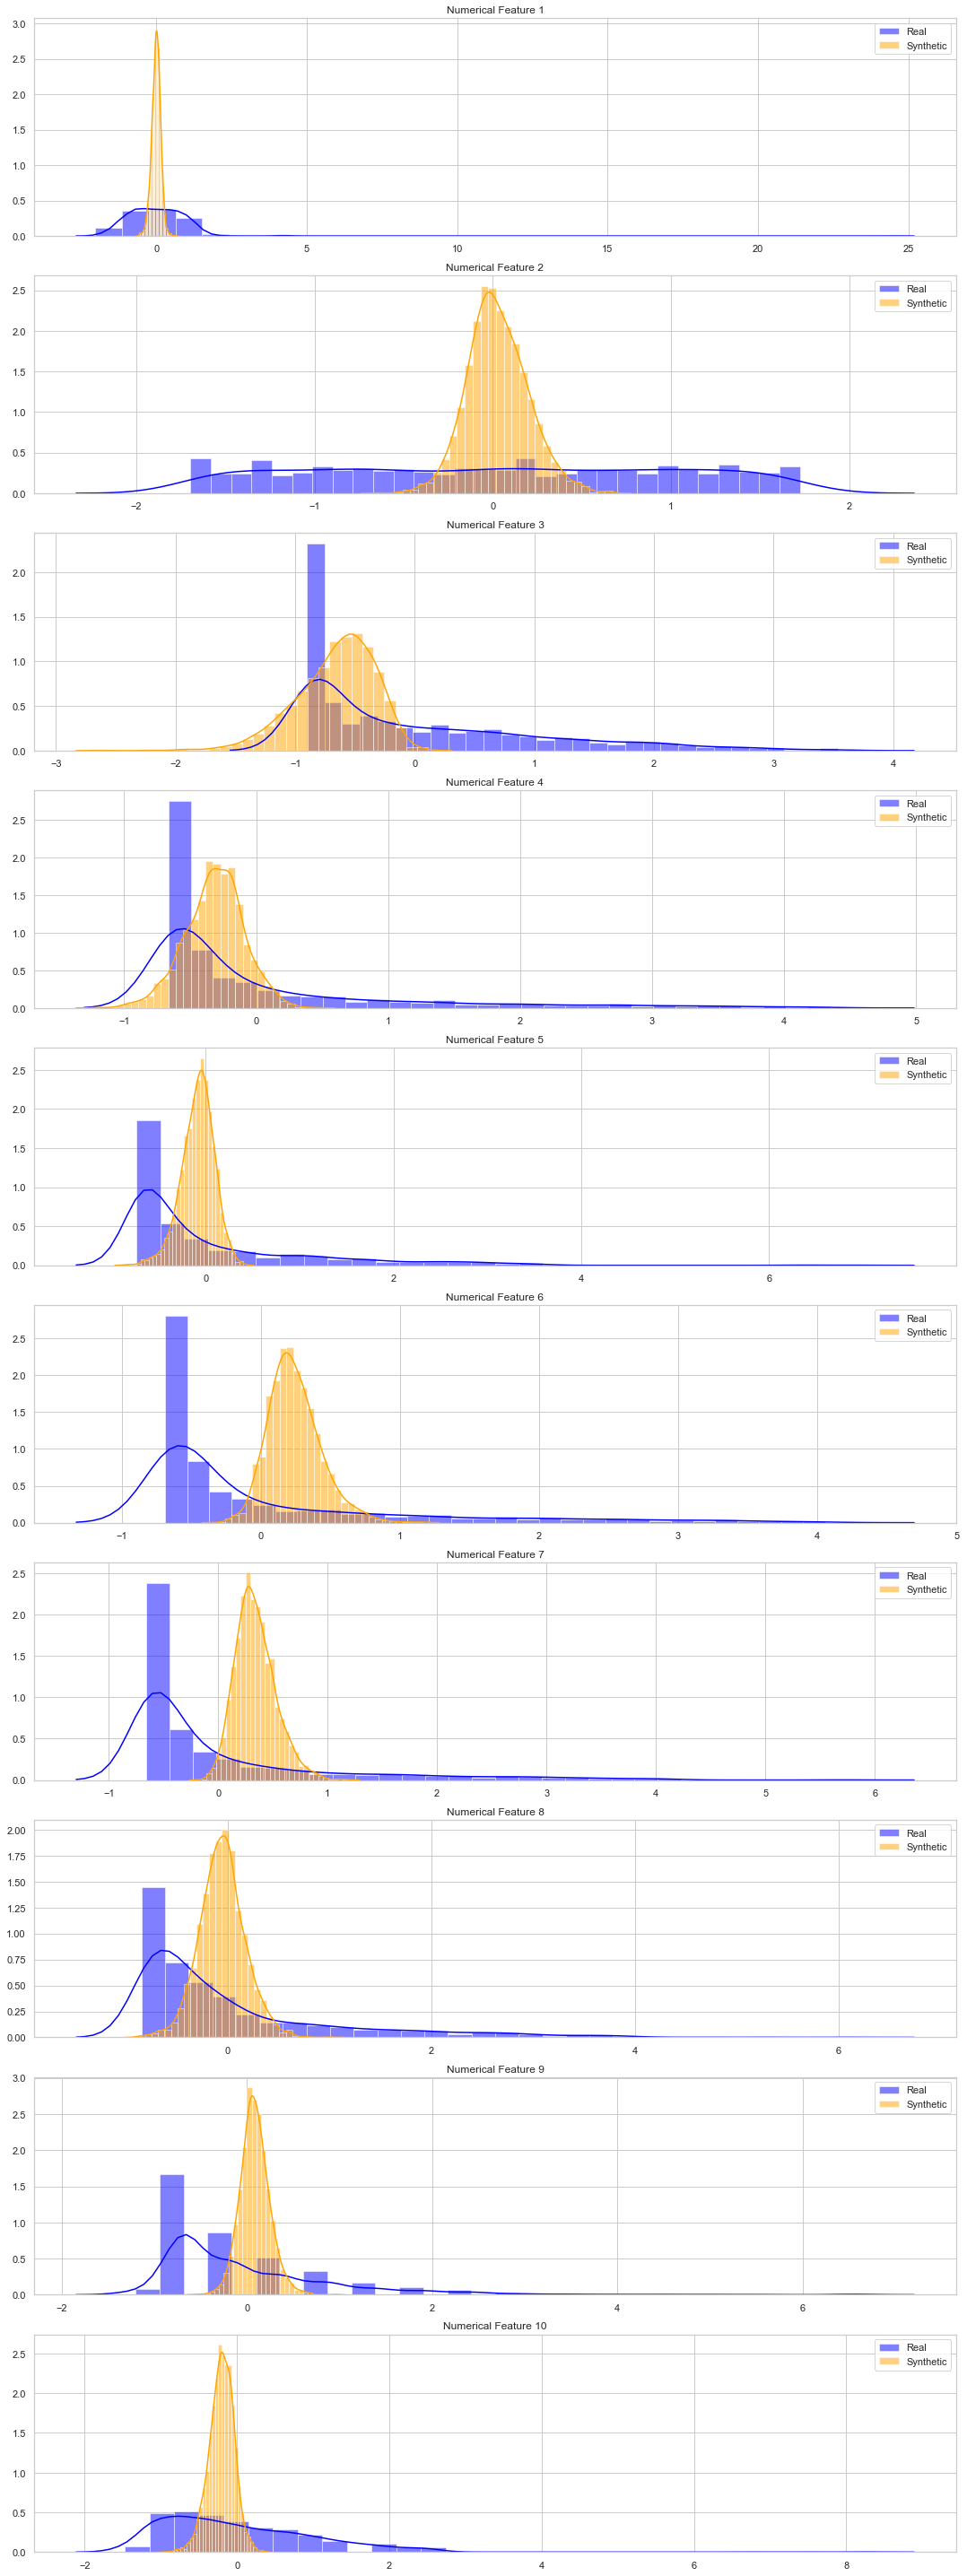

In [23]:
print("Plotting numerical distributions...")
plot_numerical_distributions(X_real_num, X_fake_num)

Plotting numerical boxplots...


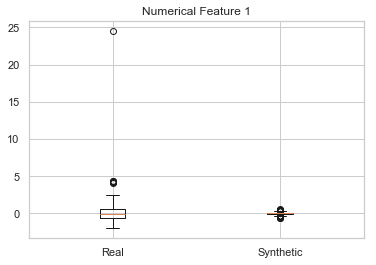

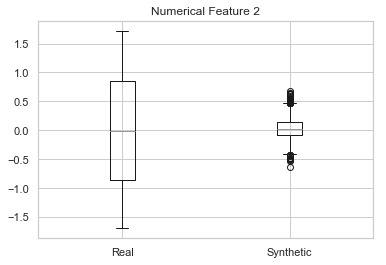

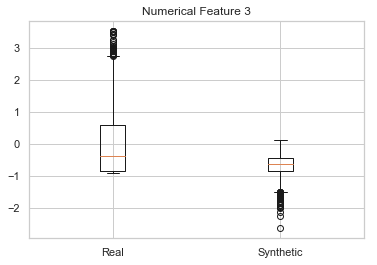

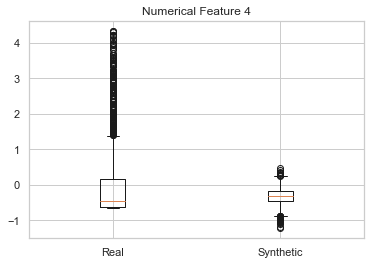

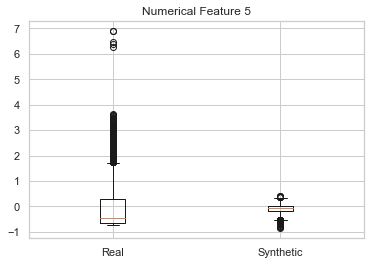

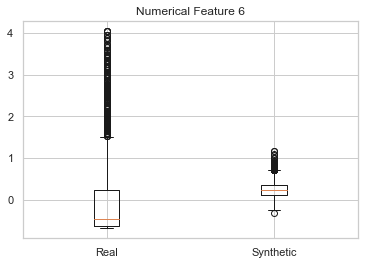

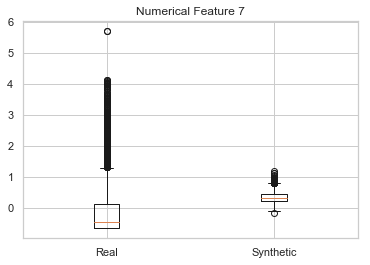

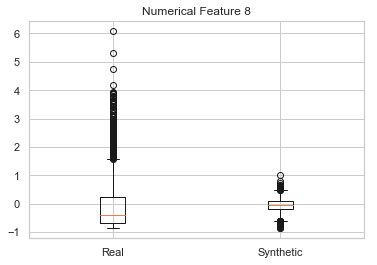

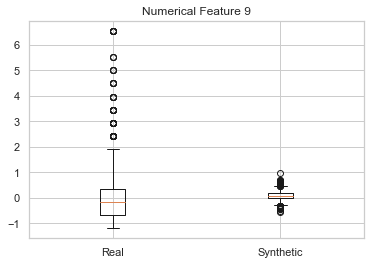

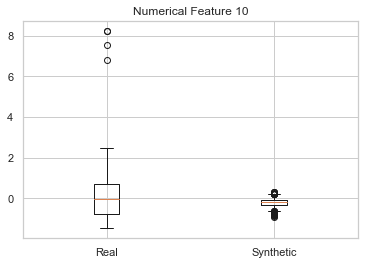

In [24]:
print("Plotting numerical boxplots...")
plot_numerical_boxplots(X_real_num, X_fake_num)

Plotting categorical frequencies...


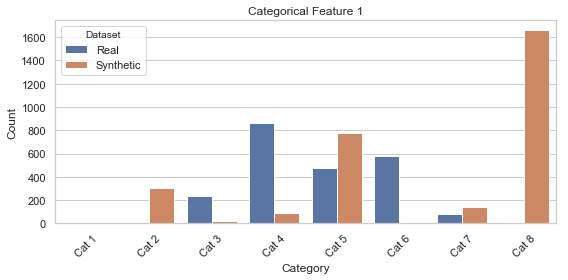

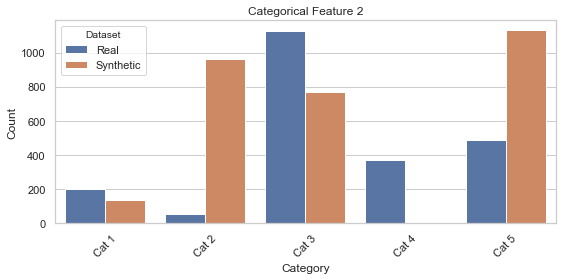

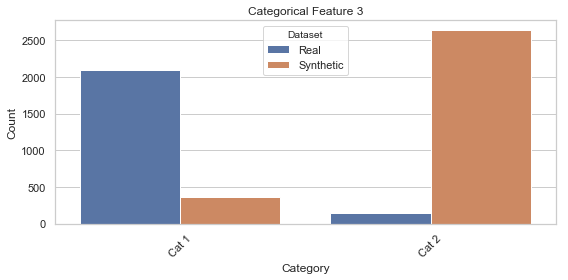

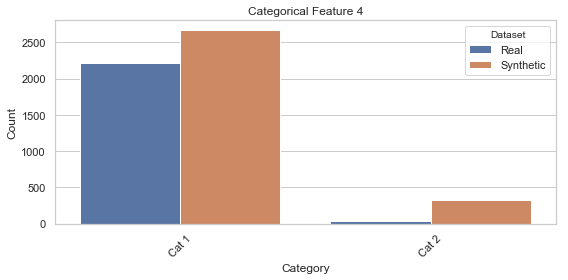

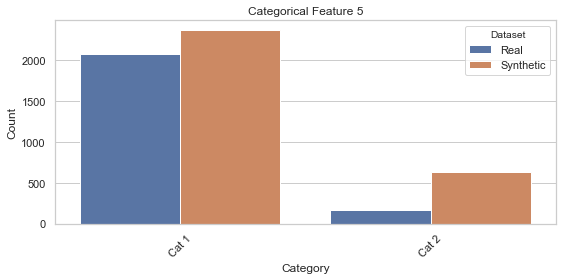

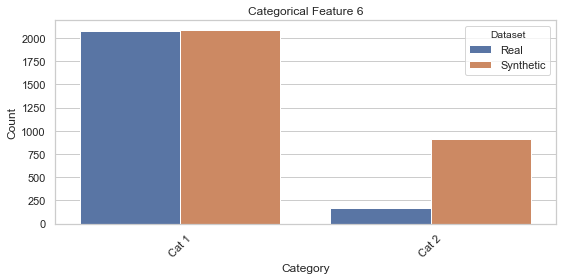

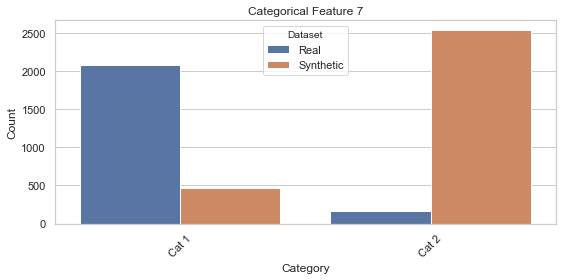

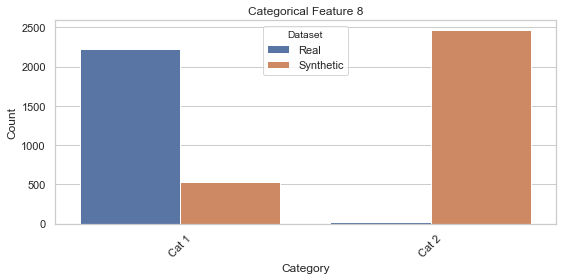

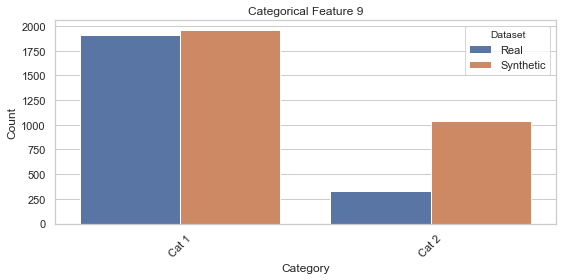

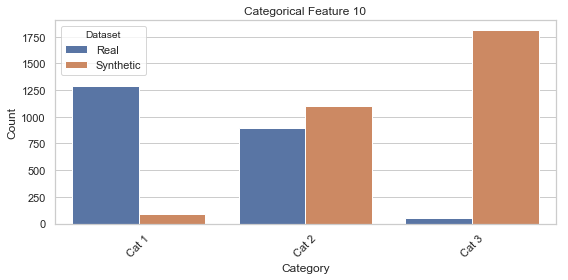

In [25]:
print("Plotting categorical frequencies...")
plot_categorical_frequencies(X_real_cat, X_fake_cat, cat_dims)